# Domain Specific Ranking Using Word2Vec

**PROTIP!** Check the other notebook first and then return here :)

Now, let's see some other useful features of Word2Vec. 

## Before starting...

As usual, let's import the tools we'll need.

In [1]:
%matplotlib inline

from helpers import *
import inspect
import matplotlib as plt
from IPython.core.pylabtools import figsize
import geopandas as gpd

figsize(20, 20)

Using TensorFlow backend.


Of course, let's load our pre-trained model into `gensim`:

In [2]:
# First, let's download the model.
unzipped = download_google_news_model()

# Then, let's create a Word2Vec model using the downloaded parameters.
gnews_model = gensim.models.KeyedVectors.load_word2vec_format(unzipped, binary=True)

## Finding entity classes in embeddings

In high-dimensional spaces are often subspaces that contain only entities of a single class. How can we find them? Well, we can train a classifier that lears to separate the true from the false positives. Our choice is an SVM.

Let's try to find countries inside the Google News Word2Vec space.

Let's begin finding things similar to Germany:

In [3]:
get_most_similar_terms(gnews_model, 'Germany')

/Users/jesusmartinez/miniconda3/envs/text-similarity/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Austria', 0.7461062669754028),
 ('German', 0.7178750038146973),
 ('Germans', 0.6628648042678833),
 ('Switzerland', 0.6506868004798889),
 ('Hungary', 0.6504982709884644),
 ('Germnay', 0.649348258972168),
 ('Netherlands', 0.6437495946884155),
 ('Cologne', 0.6430779695510864),
 ('symbol_RSTI', 0.6389946937561035),
 ('Annita_Kirsten', 0.634294867515564)]

As expected there are a number of countries nearby, but also other things that definitely aren't countries. What this tell us. is that the concept of country isn't a point, but a region in Word2Vec space. Hence, we need a good classifier to find such region.

Let's build a dataset. First, we need some positive examples (i.e. countries). In the `resources/countries.csv` we have data of some countries. Let's load them and show a few. We'll use the following function for that purpose:

In [4]:
print(inspect.getsource(load_countries))

def load_countries(source_file='resources/countries.csv'):
    with open(source_file, 'r') as f:
        countries = list(csv.DictReader(f))

    return countries



In [5]:
countries = load_countries()
for country in countries[:10]:
    print(country)

OrderedDict([('name', 'Canada'), ('cc', 'ca'), ('cc3', 'can')])
OrderedDict([('name', 'Turkmenistan'), ('cc', 'tm'), ('cc3', 'tkm')])
OrderedDict([('name', 'Ethiopia'), ('cc', 'et'), ('cc3', 'eth')])
OrderedDict([('name', 'Swaziland'), ('cc', 'sz'), ('cc3', 'swz')])
OrderedDict([('name', 'Czech_Republic'), ('cc', 'cz'), ('cc3', 'cze')])
OrderedDict([('name', 'Cameroon'), ('cc', 'cm'), ('cc3', 'cmr')])
OrderedDict([('name', 'UAE'), ('cc', 'ae'), ('cc3', 'are')])
OrderedDict([('name', 'Liberia'), ('cc', 'lr'), ('cc3', 'lbr')])
OrderedDict([('name', 'Netherlands'), ('cc', 'nl'), ('cc3', 'nld')])
OrderedDict([('name', 'East_Timor'), ('cc', 'tl'), ('cc3', 'tls')])


Great. Now we need negative examples. This one is easier. There are around 200 countries, which represent 200 words in a corpus of millions, so by sampling randomly our Word2Vec model chances of getting false negatives (countries in our not_countries set) is really, really, **really** small.

Let's use the `random_sample_words` for this:

In [6]:
print(inspect.getsource(random_sample_words))

def random_sample_words(model, sample_size):
    return random.sample(model.vocab.keys(), sample_size)



In [7]:
NEGATIVE_SAMPLE_SIZE = 5000
not_countries = random_sample_words(gnews_model, NEGATIVE_SAMPLE_SIZE)
print(not_countries[:10])

['Ms._MALVEAUX', 'dialogic', 'tasty_concoctions', 'John_Liviakis', 'PopUp', 'Hubert_Yoshida_Hitachi_Data', 'Andrew_Buckle', 'spokesman_Shi_Guizhong', 'Ventureforth', 'Argentinian_tango']


Let's now create our labeled set.

In [8]:
print(inspect.getsource(create_training_set))

def create_training_set(model, positives, negatives):
    labeled = [(p['name'], 1) for p in positives] + [(n, 0) for n in negatives]
    labeled = list(filter(lambda x: x[0] in model, labeled))

    random.shuffle(labeled)

    X = []
    y = []

    for word, label in labeled:
        X.append(model[word])
        y.append(label)

    X = np.asarray(X)
    y = np.asarray(y)

    return labeled, X, y



In [9]:
labeled, X, y = create_training_set(gnews_model, countries, not_countries)

print(f'# labeled: {len(labeled)}')
print(labeled[:20])
print(f'# X: {len(X)}')
print(f'# y: {len(y)}')

# labeled: 5184
[('Cotton_Growers_Cooperative', 0), ('de_Villiers_JP_Duminy', 0), ('PRNewswire_FirstCall_WaferGen_Biosystems', 0), ('DX##SO', 0), ('Perez', 0), ('Selling', 0), ('Mercantile_Bancorp.', 0), ('Marty_Verner', 0), ('Salt_Cay', 0), ('attorney_Howard_Srebnick', 0), ('DD#.#', 0), ('Cifer', 0), ('Kefta_Dynamic_Targeting', 0), ('Arrius', 0), ('Sindh_Baluchistan', 0), ('BJ_Koubaroulis', 0), ('Domestic_Abuse_Awareness_Month', 0), ('Liekki', 0), ('Tripp_Messick', 0), ('Raleigh_Audrey_McKoy', 0)]
# X: 5184
# y: 5184


Given our data comes already shuffled, we can split it into train and test sets manually, like this:

In [10]:
TRAINING_FRACTION = 0.7
split_point = int(TRAINING_FRACTION * len(labeled))

X_train = X[:split_point]
y_train = y[:split_point]
X_test = X[split_point:]
y_test = y[split_point:]

Now, time to train!

In [11]:
classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

How **precise** is our model?

In [12]:
predictions = classifier.predict(X_test)

missed = [country 
          for (prediction, truth, country) in 
          zip(predictions, y_test, labeled[split_point:]) 
          if prediction != truth]
precision = 100 - 100 * float(len(missed)) / len(predictions)
print(f'# missed: {len(missed)}')
print(f'Precision: {precision}')

# missed: 3
Precision: 99.80719794344473


We can use our model to make predictions on **all** the words in the pretrained model:

In [13]:
print(inspect.getsource(get_all_predictions))

correct, not_correct = get_all_predictions(classifier, gnews_model)

print('Correct sample: ')
print(random.sample(correct, 20))
print('------')
print('Incorrect sample: ')
print(random.sample(not_correct, 20))

def get_all_predictions(classifier, model):
    all_predictions = classifier.predict(model.wv.vectors)

    correct = []
    not_correct = []

    for word, prediction in zip(model.index2word, all_predictions):
        if prediction == 0:
            not_correct.append(word)
        else:
            correct.append(word)

    return correct, not_correct

Correct sample: 
["B'desh", 'FIBA_Diamond', 'Riyadh_Saudi_Arabia', 'Tamil_diaspora', 'UVU', 'Algarve_Cup', 'Belgrade_Serbia', 'Iceland', 'FYR_Macedonia', 'Christian_Estrosi', 'multination', 'Nordics', 'Kurdish_guerrillas', 'Falklands_Islands', 'Algerians', 'Ankara_Turkey', 'Guyana', 'Melaka', 'Galapagos_Islands', 'Parkersburg_W.Va.']
------
Incorrect sample: 
['M_Clapperton', 'www.vipernetworks.com', 'Edward_Indakwa', 'Prednisone_steroid', 'Jervey', 'Riley_McDermid', 'Third_Quarter_Fiscal', 'Naushad_Merali', 'Somewhat_ironically', 'paidcritics.com', 'TDS###', 'paceless', 'Jaylan_Walker_9', 'WestLB_Equity', 'GRAYDON', 'lateral_rigidity'

## Calculating Semantic Distances Inside a Class

Another useful application of Word2Vec embeddings is that we can find words related to a particular topic, concept or class. For instance, we can see what countries are closely related to coffee (maybe because they consume it a lot or because they produce it, like Colombia).

We can perform this task by ranking the members of a class (countries in this case) agasint the criterion (coffee) based on their relative distance to it.

In [14]:
# Links countries to an index.
country_to_index = {country['name']: index for index, country in enumerate(countries)}

# Get the vector associate to each country.
country_vectors = np.asarray([gnews_model[country['name']] 
                              for country 
                              in countries 
                              if country['name'] in gnews_model])

print(f'country_vectors shape: {country_vectors.shape}')

country_vectors shape: (184, 300)


Just to verify we're on the right path, let's see what's similar to Canada:

In [15]:
distances = np.dot(country_vectors, country_vectors[country_to_index['Canada']])

for index in reversed(np.argsort(distances)[-10:]):
    print(countries[index]['name'], distances[index])

Canada 7.544024
New_Zealand 3.9619699
Finland 3.9392407
Puerto_Rico 3.838145
Jamaica 3.8102932
Sweden 3.8042789
Slovakia 3.703874
Australia 3.671101
Bahamas 3.6240416
United_States 3.5374339


Well, it makes sense. Most countries related to Canada speak English, and others like Sweden or Slovakia are pretty adept to hockey.

We'll use the function `rank_countries` to determine which countries are more relevant given a particular term or criteria:

In [16]:
print(inspect.getsource(rank_countries))

rank_countries(gnews_model, 'coffee', countries, country_vectors)

def rank_countries(model, term, countries, country_vectors, top_n=10, field='name'):
    if term not in model:
        return []

    vector = model[term]
    distances = np.dot(country_vectors, vector)

    return [(countries[index][field], float(distances[index]))
            for index in reversed(np.argsort(distances)[-top_n:])]



[('Ethiopia', 1.9432250261306763),
 ('Kenya', 1.9391343593597412),
 ('Colombia', 1.9116394519805908),
 ('Burundi', 1.885450839996338),
 ('Tanzania', 1.883944034576416),
 ('Uganda', 1.7865114212036133),
 ('East_Timor', 1.7661278247833252),
 ('Rwanda', 1.7186617851257324),
 ('Djibouti', 1.670926570892334),
 ('Costa_Rica', 1.6578598022460938)]

Given the model we are using was trained on Google News, these results are biased by the appearance of these countries and the word 'coffee' in the same context. Nevertheless, they look quite good, don't you think?

## Visualizing Country Data on a Map

We can use all the tools we defined in the cells above to visualize countries that rink higher on a certain criteria in a world map. We'll leverage the power of `GeoPandas` for this task.

Let's start small. We'll just load the entire world :)

In [18]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


We can use the `map_term` to highlight countries that rank higher on a certain criteria like, for instance, consuming or producing lots of coffee.

def map_term(model, term, countries, country_vectors, world):
    d = {key.upper(): value
         for key, value
         in rank_countries(model, term, countries, country_vectors, top_n=0, field='cc3')}

    world[term] = world['iso_a3'].map(d)
    world[term] /= world[term].max()
    world.dropna().plot(term, cmap='OrRd')



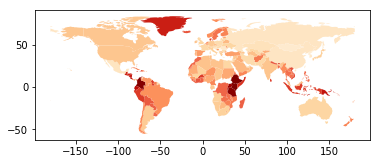

In [20]:
print(inspect.getsource(map_term))

map_term(gnews_model, 'coffee', countries, country_vectors, world)

Visualizing our data is a crucial part of machine learning. Whether on a map or a more traditional plot, to see what's happening in our data can lead us to powerful insights with the potential of translating into performant models.

It also tells us if something's not right. For instance, do Greenlandics drink or produce that much coffee? Or is it an effect of the existence of a variation of an Irish coffe called Greenlandic coffee?